# Log RV forecast model for CBA Stock
***
Task: Build a model to forecast the one-day-ahead of log RV of CBA

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Read in the database

In [2]:
conn = sqlite3.connect('cba_log_rv.sqlite')

query = '''SELECT log_rv.log_rv, 
           log_rv_feature.log_rv_lag1, log_rv_feature.log_rv_avg5, log_rv_feature.log_rv_avg22, log_rv_feature.log_rv_avg253, log_rv_feature.log_rv_up,
           rng_feature.rng_lag1, rng_feature.rng_avg5, rng_feature.rng_avg22, rng_feature.rng_avg253, rng_feature.rng_up,
           qtl_rng_feature.qtl_rng_lag1, qtl_rng_feature.qtl_rng_avg5, qtl_rng_feature.qtl_rng_avg22, qtl_rng_feature.qtl_rng_avg253, qtl_rng_feature.qtl_rng_up
           FROM log_rv
           JOIN log_rv_feature ON log_rv.date = log_rv_feature.date
           JOIN rng_feature ON log_rv.date = rng_feature.date
           JOIN qtl_rng_feature ON log_rv.date = qtl_rng_feature.date;'''

df = pd.read_sql(query, conn)

## 2. Inspect the data

In [3]:
df.head()

,log_rv,log_rv_lag1,log_rv_avg5,log_rv_avg22,log_rv_avg253,log_rv_up,rng_lag1,rng_avg5,rng_avg22,rng_avg253,rng_up,qtl_rng_lag1,qtl_rng_avg5,qtl_rng_avg22,qtl_rng_avg253,qtl_rng_up
0,-0.195388,-0.741694,-0.449644,-0.515572,-0.367086,0,0.323813,0.607873,0.553536,0.703900,0,0.269568,0.320090,0.304471,0.309980,0
1,-0.779210,-0.195388,-0.545231,-0.521978,-0.365305,0,0.685980,0.524683,0.544489,0.705035,0,0.361912,0.321091,0.307479,0.310409,0
2,-0.196713,-0.779210,-0.463997,-0.551932,-0.365947,0,0.398439,0.523289,0.535820,0.704763,0,0.271133,0.320783,0.303049,0.310296,0
3,0.067592,-0.196713,-0.436124,-0.567596,-0.363599,0,0.795818,0.557333,0.537353,0.705806,0,0.286407,0.311396,0.297146,0.310441,0
4,-0.838226,0.067592,-0.369083,-0.543945,-0.359683,0,0.614600,0.563730,0.537039,0.706781,0,0.434706,0.324745,0.304952,0.311234,0


[Text(0, 0, 'log_rv'),
 Text(1, 0, 'log_rv_lag1'),
 Text(2, 0, 'log_rv_avg5'),
 Text(3, 0, 'log_rv_avg22'),
 Text(4, 0, 'log_rv_avg253'),
 Text(5, 0, 'log_rv_up'),
 Text(6, 0, 'rng_lag1'),
 Text(7, 0, 'rng_avg5'),
 Text(8, 0, 'rng_avg22'),
 Text(9, 0, 'rng_avg253'),
 Text(10, 0, 'rng_up'),
 Text(11, 0, 'qtl_rng_lag1'),
 Text(12, 0, 'qtl_rng_avg5'),
 Text(13, 0, 'qtl_rng_avg22'),
 Text(14, 0, 'qtl_rng_avg253'),
 Text(15, 0, 'qtl_rng_up')]

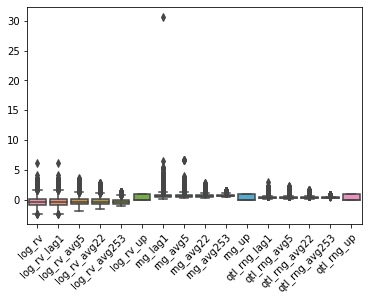

In [4]:
ax = sns.boxplot(data=df)
ax.set_xticklabels(df, rotation=45, ha="right", rotation_mode="anchor")

[Text(0, 0, 'log_rv'),
 Text(1, 0, 'log_rv_lag1'),
 Text(2, 0, 'log_rv_avg5'),
 Text(3, 0, 'log_rv_avg22'),
 Text(4, 0, 'log_rv_avg253'),
 Text(5, 0, 'log_rv_up'),
 Text(6, 0, 'rng_lag1'),
 Text(7, 0, 'rng_avg5'),
 Text(8, 0, 'rng_avg22'),
 Text(9, 0, 'rng_avg253'),
 Text(10, 0, 'rng_up'),
 Text(11, 0, 'qtl_rng_lag1'),
 Text(12, 0, 'qtl_rng_avg5'),
 Text(13, 0, 'qtl_rng_avg22'),
 Text(14, 0, 'qtl_rng_avg253'),
 Text(15, 0, 'qtl_rng_up')]

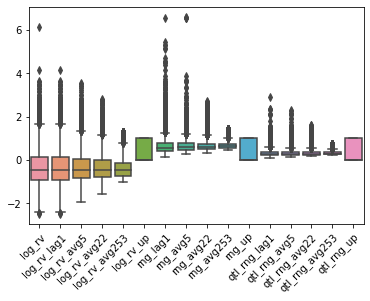

In [5]:
# Since removing the outliers greatly decreases our predictive power, only remove the extreme outlier shown in rng_lag1. 
upper_limit = 25
df = df[(df.rng_lag1<upper_limit)]

ax = sns.boxplot(data=df)
ax.set_xticklabels(df, rotation=45, ha="right", rotation_mode="anchor")

## 3. Feature Selection


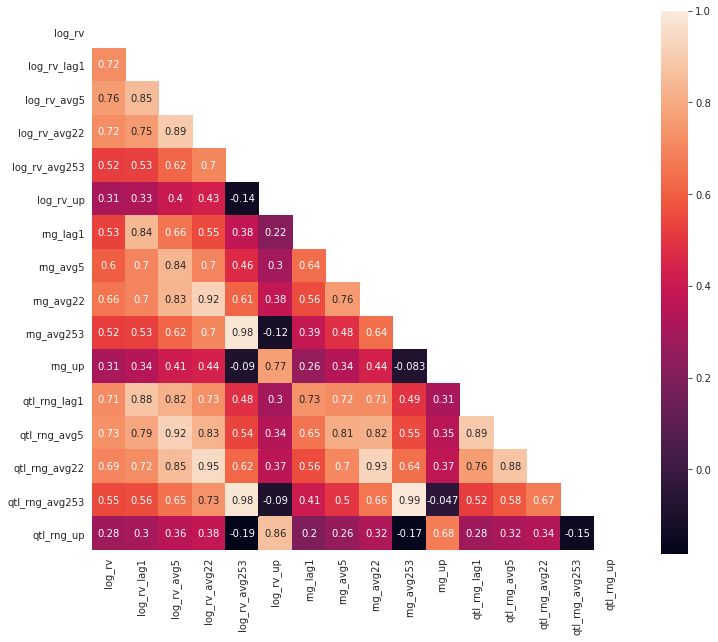

In [6]:
# Using Pearson Correlation to plot heatmap
# Find features that are highly correlated with log_rv
plt.figure(figsize=(12,10))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,annot=True)

In [7]:
# Remove features with correlation less than 0.5
df = df.drop(['log_rv_up','rng_up','qtl_rng_up'], axis=1)
X = df.drop('log_rv', axis=1)
y = df['log_rv']

In [8]:
# Multicollinearity: Find features that are highly correlated with each other
# Method 1: Variance Inflation Factor (VIF) Analysis
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,log_rv_lag1,17.729021
1,log_rv_avg5,34.430943
2,log_rv_avg22,33.639220
3,log_rv_avg253,12.621410
4,rng_lag1,14.052023
5,rng_avg5,21.793470
6,rng_avg22,68.580131
7,rng_avg253,581.786792
8,qtl_rng_lag1,46.962737
9,qtl_rng_avg5,112.047297


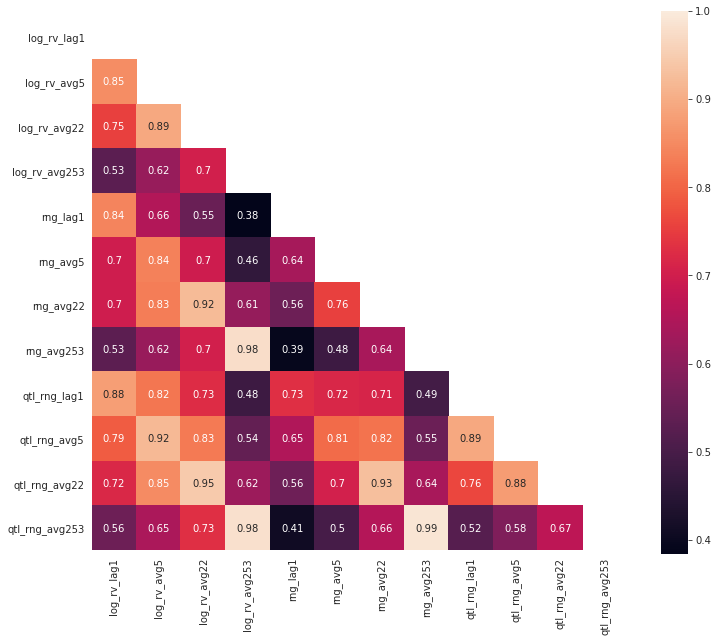

In [9]:
# Method 2: Correlation Analysis
# Using Pearson Correlation to plot heatmap
plt.figure(figsize=(12,10))
corr = X.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,annot=True)


In [10]:
# Remove features that have correlation with more than 0.85
# https://rahulgupta1.medium.com/feature-engineering-checklist-7926ca3311b7

def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range (len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X, 0.85)
len(set(corr_features))

8

In [11]:
corr_features

{'log_rv_avg22',
 'log_rv_avg5',
 'qtl_rng_avg22',
 'qtl_rng_avg253',
 'qtl_rng_avg5',
 'qtl_rng_lag1',
 'rng_avg22',
 'rng_avg253'}

In [12]:
df = df.drop(corr_features, axis=1)
X = X.drop(corr_features, axis=1)

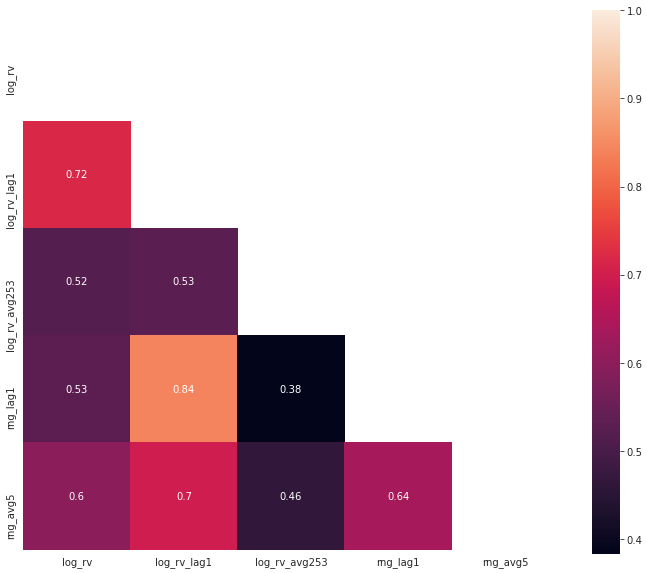

In [13]:
# Using Pearson Correlation to plot heatmap
# Visualisation of potential features to use for model building
plt.figure(figsize=(12,10))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,annot=True)

## 4. Modelling


In [14]:
# 60:20:20 split
X_tv, X_test, y_tv, y_test = train_test_split(X,y,test_size=0.20,random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_tv, y_tv, test_size = 1/4,random_state=0) 

X_train.shape, X_vali.shape, X_test.shape

((2818, 4), (940, 4), (940, 4))

## Model 1

In [15]:
# log_rv = beta0 + beta1*log_rv_lag1

X_train1 = X_train[['log_rv_lag1']].to_numpy()
X_test1 = X_test[['log_rv_lag1']].to_numpy()
X_vali1 = X_vali[['log_rv_lag1']].to_numpy()
X_tv1 = X_tv[['log_rv_lag1']].to_numpy()
y_train1 = y_train.to_numpy()
y_test1 = y_test.to_numpy()
y_vali1 = y_vali.to_numpy()
y_tv1 = y_tv.to_numpy()

In [16]:
linear_reg1 = LinearRegression()
linear_reg1.fit(X_train1, y_train1)

print("beta 0: {:.4f}".format(linear_reg1.intercept_))
for i in range(1):
    print('beta {}: {:.4f}'.format(i+1, linear_reg1.coef_[i]))

beta 0: -0.0923
beta 1: 0.7078


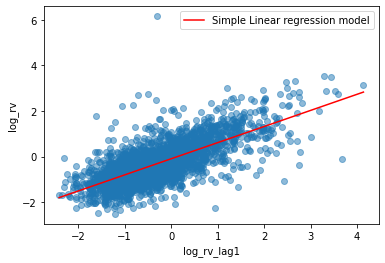

In [17]:
xx = np.linspace(X_train1.min(), X_train1.max(), 100)
yy = linear_reg1.intercept_ + linear_reg1.coef_[0]*xx

plt.scatter(X_train1,y_train1,alpha=0.5)
plt.plot(xx,yy,color = 'red', label = 'Simple Linear regression model')
plt.xlabel('log_rv_lag1')
plt.ylabel('log_rv')
plt.legend()
plt.savefig('plot')

In [18]:
# ----------------------------------
# Predict with your regression model
# ----------------------------------
pred_train1 = linear_reg1.predict(X_train1)
pred_vali1 = linear_reg1.predict(X_vali1)

# -----------------
# Calculate the MSE
# -----------------
mse_train1 = mse(pred_train1, y_train1)
mse_vali1 = mse(pred_vali1, y_vali1)

print("Train mse: {:.4f}".format(mse_train1))
print("Validation mse: {:.4f}".format(mse_vali1))

Train mse: 0.3723
Validation mse: 0.3741


In [19]:
linear_reg1 = LinearRegression()
linear_reg1.fit(X_tv1,y_tv1)

# ------------------------
# Predict on the test data
# ------------------------
pred_test1 = linear_reg1.predict(X_test1)

# -----------------
# Calculate the MSE
# -----------------
mse_test1 = mse(pred_test1, y_test1)

print("Model 1 Test MSE: {:.4f}".format(mse_test1))

Model 1 Test MSE: 0.3581


## Model 2

In [20]:
#log_rv = beta0 + beta1*log_rv_lag1 + beta2*log_rv_avg253 + beta3*rng_lag1 + beta4*rng_avg5

X_train2 = X_train[['log_rv_lag1','log_rv_avg253','rng_lag1','rng_avg5']].to_numpy()
X_test2 = X_test[['log_rv_lag1','log_rv_avg253','rng_lag1','rng_avg5']].to_numpy()
X_vali2 = X_vali[['log_rv_lag1','log_rv_avg253','rng_lag1','rng_avg5']].to_numpy()
X_tv2 = X_tv[['log_rv_lag1','log_rv_avg253','rng_lag1','rng_avg5']].to_numpy()
y_train2 = y_train.to_numpy()
y_test2 = y_test.to_numpy()
y_vali2 = y_vali.to_numpy()
y_tv2 = y_tv.to_numpy()

In [21]:
linear_reg2 = LinearRegression()
linear_reg2.fit(X_train2, y_train2)

print("beta 0: {:.4f}".format(linear_reg2.intercept_))
for i in range(4):
    print('beta {}: {:.4f}'.format(i+1, linear_reg2.coef_[i]))

beta 0: 0.0332
beta 1: 0.7235
beta 2: 0.2418
beta 3: -0.4654
beta 4: 0.3987


In [22]:
# ----------------------------------
# Predict with your regression model
# ----------------------------------
pred_train2 = linear_reg2.predict(X_train2)
pred_vali2 = linear_reg2.predict(X_vali2)

# -----------------
# Calculate the MSE
# -----------------
mse_train2 = mse(pred_train2, y_train2)
mse_vali2 = mse(pred_vali2, y_vali2)

print("Train mse: {:.4f}".format(mse_train2))
print("Validation mse: {:.4f}".format(mse_vali2))

Train mse: 0.3268
Validation mse: 0.3176


In [23]:
linear_reg2 = LinearRegression()
linear_reg2.fit(X_tv2,y_tv2)

# ------------------------
# Predict on the test data
# ------------------------
pred_test2 = linear_reg2.predict(X_test2)

# -----------------
# Calculate the MSE
# -----------------
mse_test2 = mse(pred_test2, y_test2)

print("Model 2 Test MSE: {:.4f}".format(mse_test2))

Model 2 Test MSE: 0.3311


## Model 3

In [24]:
# After building an individual polynomial regression model for all four features, only log_rv_lag1 has an 
# MSE of < 0.4, which is the benchmark we have set from Model 1 and 2.
# See Appendix 2
# log_rv = beta0 + beta1*log_rv_lag1 + beta2*log_rv_lag1^2 + ...

X_train3 = X_train[['log_rv_lag1']].to_numpy()
X_vali3 = X_vali[['log_rv_lag1']].to_numpy()
X_test3 = X_test[['log_rv_lag1']].to_numpy()
X_tv3 = X_tv[['log_rv_lag1']].to_numpy()
y_train3 = y_train.to_numpy()
y_vali3 = y_vali.to_numpy()
y_test3 = y_test.to_numpy()
y_tv3 = y_tv.to_numpy()

for q in range(7):
    X_train3 = np.column_stack((X_train3,X_train3[:,0]**(q+2)))
    
for q in range(7):
    X_vali3 = np.column_stack((X_vali3,X_vali3[:,0]**(q+2)))
    
for q in range(7):
    X_test3 = np.column_stack((X_test3,X_test3[:,0]**(q+2)))
    
for q in range(7):
    X_tv3 = np.column_stack((X_tv3,X_tv3[:,0]**(q+2)))

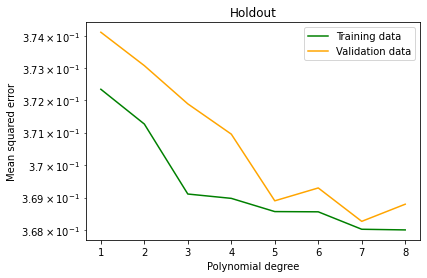

In [25]:
mse_train = []
mse_vali = []

max_deg = 8
degrees = range(1, max_deg+1)

for deg in degrees:

    # -----------------------------------
    # Build and fit your regression model
    # -----------------------------------
    linear_reg3 = LinearRegression()
    linear_reg3.fit(X_train3[:,:deg],y_train3)

    # ----------------------------------
    # Predict with your regression model
    # ----------------------------------
    pred_train3 = linear_reg3.predict(X_train3[:,:deg])
    pred_vali3 = linear_reg3.predict(X_vali3[:,:deg])

    # -----------------
    # Calculate and save the MSE
    # -----------------
    mse_train.append(mse(pred_train3, y_train3))
    mse_vali.append(mse(pred_vali3, y_vali3))

# ------------------------
# Plot the holdout results (Do not modify)
# ------------------------
plt.plot(degrees, mse_train, color = 'green', label = 'Training data')
plt.plot(degrees, mse_vali, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.title('Holdout')
plt.xticks(degrees)
plt.yscale('log')
plt.legend()

In [26]:
# Polynomial degree of 7 is ideal because the validation MSE is low while being only slightly higher than the training MSE,
# indicating a good fit. Polynomial degree with the smallest difference between training and validation data.

for i in range(8):
    print('Poly {}: {:.6f}'.format(i+1, mse_vali[i]))

Poly 1: 0.374117
Poly 2: 0.373078
Poly 3: 0.371891
Poly 4: 0.370954
Poly 5: 0.368899
Poly 6: 0.369295
Poly 7: 0.368268
Poly 8: 0.368795


In [27]:
linear_reg3 = LinearRegression()
linear_reg3.fit(X_train3[:,:7], y_train3)

print("beta 0: {:.4f}".format(linear_reg3.intercept_))
for i in range(7):
    print('beta {}: {:.4f}'.format(i+1, linear_reg3.coef_[i]))

beta 0: -0.1391
beta 1: 0.8033
beta 2: 0.1560
beta 3: -0.0464
beta 4: -0.0560
beta 5: 0.0081
beta 6: 0.0068
beta 7: -0.0013


In [28]:
# ----------------------------------
# Predict with your regression model
# ----------------------------------
pred_train3 = linear_reg3.predict(X_train3[:,:7])
pred_vali3 = linear_reg3.predict(X_vali3[:,:7])

# -----------------
# Calculate the MSE
# -----------------
mse_train3 = mse(pred_train3, y_train3)
mse_vali3 = mse(pred_vali3, y_vali3)

print("Train mse: {:.4f}".format(mse_train3))
print("Validation mse: {:.4f}".format(mse_vali3))

Train mse: 0.3680
Validation mse: 0.3683


In [29]:
linear_reg3 = LinearRegression()
linear_reg3.fit(X_tv3[:,:7],y_tv3)

# ------------------------
# Predict on the test data
# ------------------------
pred_test3 = linear_reg3.predict(X_test3[:,:7])

# -----------------
# Calculate the MSE
# -----------------
mse_test3 = mse(pred_test3, y_test3)

print("Model 3 Test MSE: {:.4f}".format(mse_test3))

Model 3 Test MSE: 0.3524
